# Kernel regression

Last section we looked at kernel density estimators, or ways of approximating the probability density function of a single random variable: $f(x)$. Now we want to do something a bit more ambitious: estimate the expectation of a random variable $Y$ conditional on another random variable $X$: $E(Y|X)$. We know from Sofia's class that the best _linear approximation_ of this conditional expectation is equal to $(X'X)^{-1}X'Y$. But what if we think the relationship is non-linear, and want to get this right? Then we can use kernel regression.

Formally, suppose we have a true model of the shape:

$$y = m(X) + e$$

but we don't know the shape of the function $m()$. If we assume that $E(e|X) = 0$, then we can derive the kernel regression estimator (see Ethan's notes for math):

$$\widehat{m}(x) = \frac{\sum_i k(\frac{X_i-x}{h})y_i}{\sum_i k(\frac{X_i-x}{h})}$$

You can program this similarly as we did before...

In [1]:
import numpy as np
from scipy.stats import distributions as iid
from numpy import random
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
# define true conditional expectation
def m(x): 
    return np.sin(2*x)/(1+x)

# create DGP
def dgp(N, m):
    '''
    Generate X, Y data.
    
    Inputs
    ------
    N (int): Number of observations
    m (function): true conditional expectation
    
    Returns
    -------
    X (pd.Series): draws of independent variable
    y (pd.Series): draws of dependent variable
    '''
    # X data
    rvX = iid.uniform(0, 2*np.pi)
    X = pd.Series(rvX.rvs(size=N))
    # sort
    X = X.sort_values()
    
    # noise
    E = iid.norm(scale=0.1)
    e = E.rvs(size=N)
    
    # create Y
    y = m(X) + e
    
    return y, X

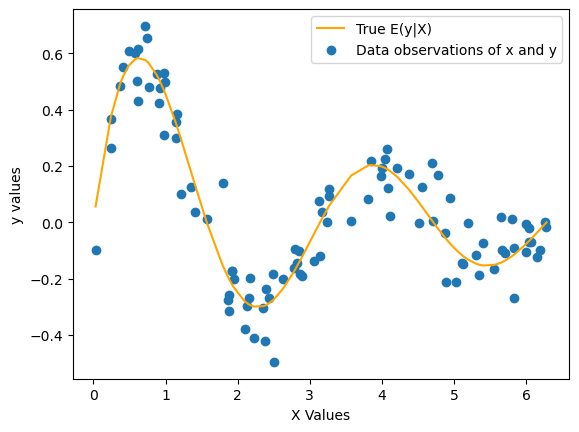

In [3]:
# create data and plot
y, X = dgp(100, m)

fig, ax = plt.subplots()
plt.scatter(X, y, label="Data observations of x and y")
plt.plot(X, m(X), label='True E(y|X)', color='orange')
ax.set(xlabel='X Values', ylabel='y values')
plt.legend()

In [4]:
def K(u):
    '''
    Gaussian kernel density at point x given data X.
    
    Inputs
    ------
    u (float): point at which to evaluate the density: x-X/h
    X (pd.Series): data to use
    h (float): bandwidth
    
    Returns
    -------
    k(u) (pd.Series): kernel 
    '''
    return (1/(2*np.pi))*np.exp(-u**2/2)

In [5]:
def mhat(x, k, X, h, y):
    '''
    Kernel regression
    
    Inputs
    -----
    x (float): point at which to estimate the kernel regression
    k (function): kernel function to use; function of u only.
    X (pd.Series): data
    y (pd.Series): data outcome variable
    
    Returns
    -------
    mhat(x) (float): kernel regression estimate
    
    '''
    u = (x-X)/h
    return (k(u)*y).sum()/k(u).sum()

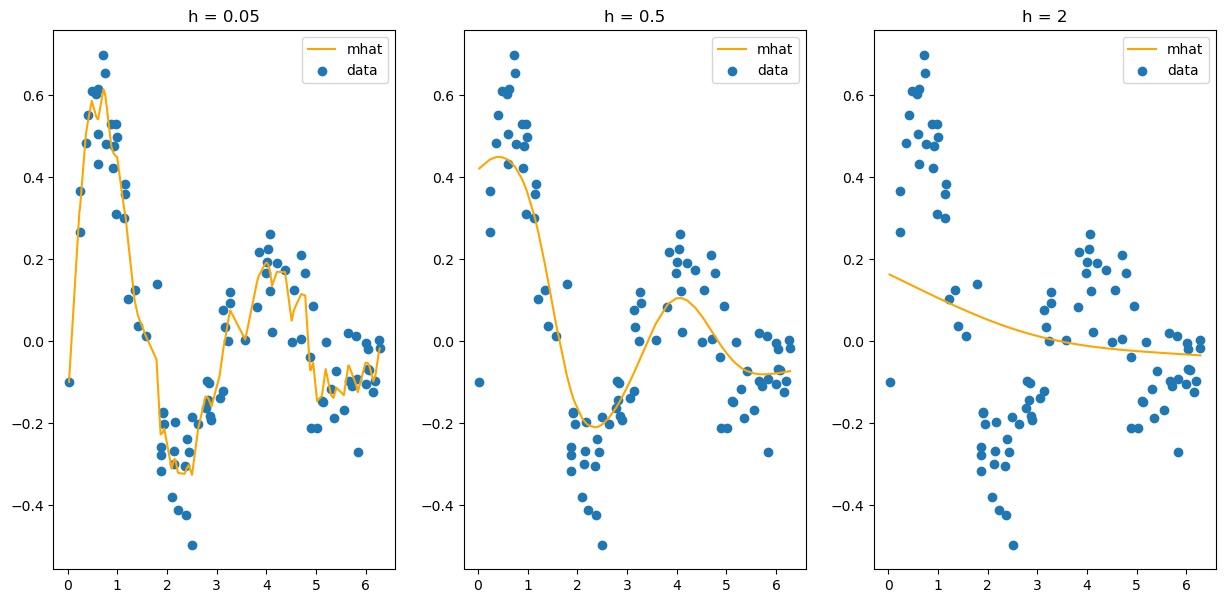

In [42]:
# estimate kernel regression for 2 different bandwidths
hvals = [0.05, 0.5, 2]

fig, ax = plt.subplots(1, 3, figsize=(15,7))
counter = 0

for bandwidth in hvals:
    # calculate m hat
    m = X.apply(lambda x: mhat(x, K, X, bandwidth, y))
    
    # plot mhat 
    ax[counter].plot(X, m, label = 'mhat', color='orange')
    ax[counter].set_title(f'h = {bandwidth}')
    
    # plot points for reference
    ax[counter].scatter(X, y, label = 'data')
    ax[counter].legend()
    
    # advance index for next plot
    counter += 1

# Overfitting and how to judge how good we're doing

How can we evaluate how well this estimator is doing? By construction, it is doing the best estimation it can at each of the $x$ in our data, given our bandwidth. We can see that the small bandwidth is doing a little too well- it is hitting a lot of our points, but it is achieving this by overfitting the noise in the data. This means that given a new $x$ that wasn't in our data, this estimator wouldn't give an accurate idea of what the conditional expectation of $y$ is given a new data point. 

This intuition shows us why calulating the estimated mean square error isn't a great way to evaluate our estimator- mechanically, if we make the bandwidth smaller and smaller, we will get smaller errors but we won't necessarily do a good job of getting the overall shape right. In order to evaluate how well we would do given a new point, we need to so how close $\widehat{m}(x)$ gets given a new $x$ that wasn't used in the initial calculation. 

We can do this by doing something clever with our estimation: we can leave one of our data points $x_{i}$ out of the estimation of $m()$, call this $\widehat{m}_{-i}$, then evaluate how well we do by calculting $\widehat{m}(x_i)$. Then we can see how large the "out of sample" error $e_{-i} = y_i-\widehat{m}_{-i}(x_i)$. We can do this one-by-one for each $x_i$ in the data, then define the "leave-one-out" estimated mean squared error as:

$$EMSE = \frac{1}{n}\sum_i e_{-i}^2$$

## What the... what's a Gram matrix?
A gram matrix is just a convenient way to calculate all of these $\widehat{m}_{-i}$! Define the gram matrix $G$ as:

$$G = \begin{bmatrix}
k(\frac{x_1-x_1}{h}) & k(\frac{x_1-x_2}{h}) & \ldots  & k(\frac{x_1-x_N}{h})\\
\ldots & \ldots  & \ldots  & \ldots \\
k(\frac{x_N-x_1}{h}) & k(\frac{x_N-x_2}{h}) & \ldots & k(\frac{x_N-x_N}{h})
\end{bmatrix}$$

and define:

$$G_{-} = \begin{bmatrix}
0 & k(\frac{x_1-x_2}{h}) & \ldots  & k(\frac{x_1-x_N}{h})\\
\ldots & 0  & \ldots  & \ldots \\
k(\frac{x_N-x_1}{h}) & k(\frac{x_N-x_2}{h}) & \ldots & 0
\end{bmatrix}$$


Throwing back to when we remembered what matrix algebra actually is, notice that:

$$Gy = \begin{bmatrix}
\sum_i k(\frac{x_1-x_i}{h})y_i\\
\ldots \\
\sum_i k(\frac{x_N-x_i}{h})y_i
\end{bmatrix}$$

and:

$$G_{-}y = \begin{bmatrix}
\sum_{i\neq 1} k(\frac{x_1-x_i}{h})y_i\\
\ldots \\
\sum_{i\neq N} k(\frac{x_N-x_i}{h})y_i
\end{bmatrix}$$

So the Gram matrix gives us an easy way of calculating all our $\widehat{m}$ and $\widehat{m}_{-i}$ terms!

$$EMSE = \frac{1}{N} \sum y- \widehat{m}_{-} = \frac{1}{N} \sum y- \frac{G_{-}y}{G_{-}1_N}$$

In [7]:
def Gminus(k, X, h):
    '''
    Gram matrix.
    
    Inputs:
    --------
    k (function): kernel function, function of 1 input (u)
    X (np.Series): data
    h (float): bandwidth
    
    Returns:
    --------
    Gminus (np.array): NxN array of kernels
    '''
    X = np.array(X).reshape(-1,1)
    u = (X.T - X)/h # NxN matrix of x_i - x_j
    
    # applied to each u, get G
    G = k(u)
    
    # take out diagonal
    Gminus = G - np.eye(u.shape[0])*np.diagonal(G)
    return Gminus

In [16]:
def mhat_minus(k, X, h, y):
    denom = Gminus(k, X, h).sum(axis=0).reshape(-1,1)
    numer = Gminus(k, X, h)@(np.array(y).reshape(-1,1))
    return numer/denom

def EMSE(k, X, h, y):
    e = np.array(y).reshape(-1,1) - mhat_minus(k, X, h, y)
    return (e**2).mean()

Text(0, 0.5, 'EMSE')

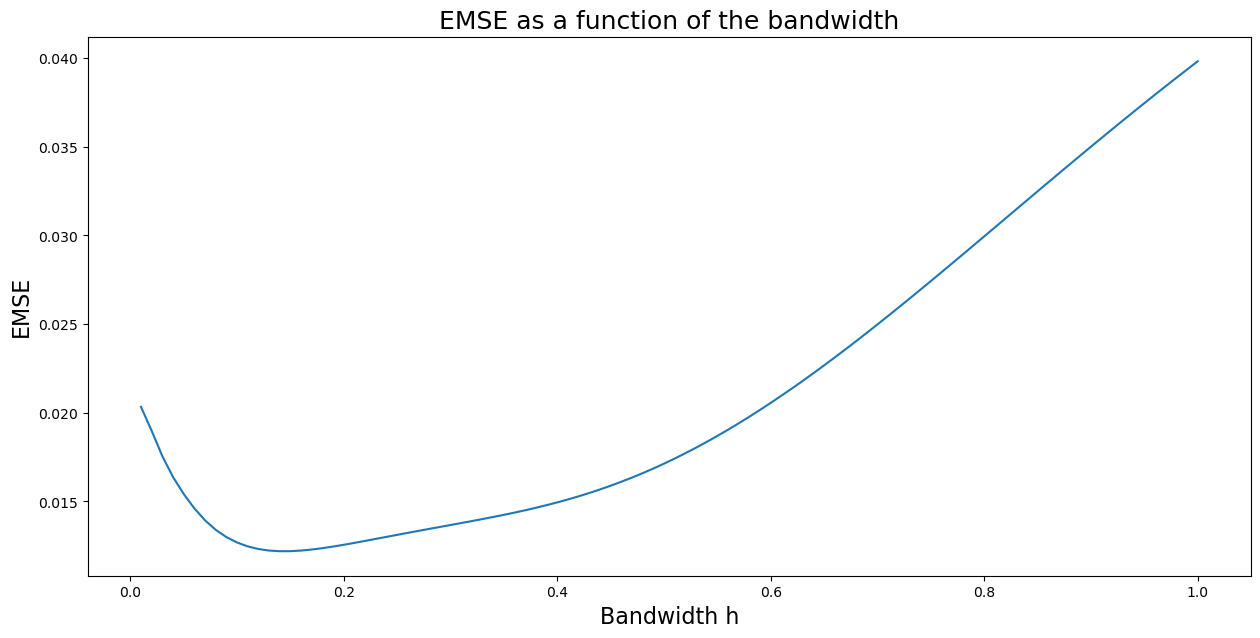

In [40]:
# EMSE for different bandwidths

h = np.linspace(0.01, 1, 100)
fig, ax = plt.subplots(1,1, figsize=(15,7))
ax.plot(h, [EMSE(K, X, bandwidth, y) for bandwidth in h])

plt.title("EMSE as a function of the bandwidth", size=18)
plt.xlabel('Bandwidth h', size=16)
plt.ylabel('EMSE', size=16)